# Modified from https://github.com/ritvikmath/YouTubeVideoCode/blob/main/Bayesian%20Time%20Series.ipynb

In [22]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
import arviz as az



# The Data

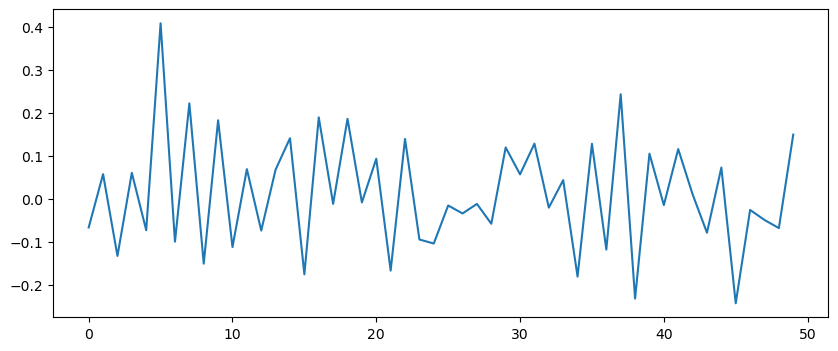

In [2]:
true_phi_1 = -0.2
true_phi_2 = 0.5
true_sigma = 0.1

xvals = [np.random.normal(0, true_sigma), np.random.normal(0, true_sigma)]
for _ in range(50):
    xvals.append(true_phi_1*xvals[-1] + true_phi_2*xvals[-2] + np.random.normal(0, true_sigma))
xvals = np.array(xvals[2:])
plt.figure(figsize=(10,4))
plt.plot(xvals)

# Usual Method : Fit AR Model

In [10]:
model = ARIMA(xvals, order=(2,0,0))
model = model.fit()

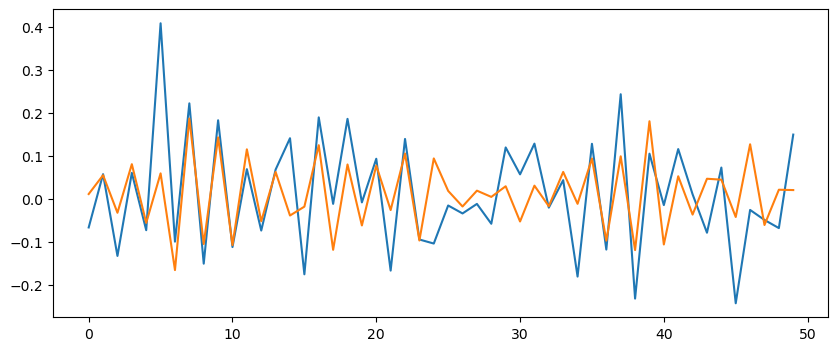

In [11]:
plt.figure(figsize=(10,4))
plt.plot(xvals)
plt.plot(model.fittedvalues)

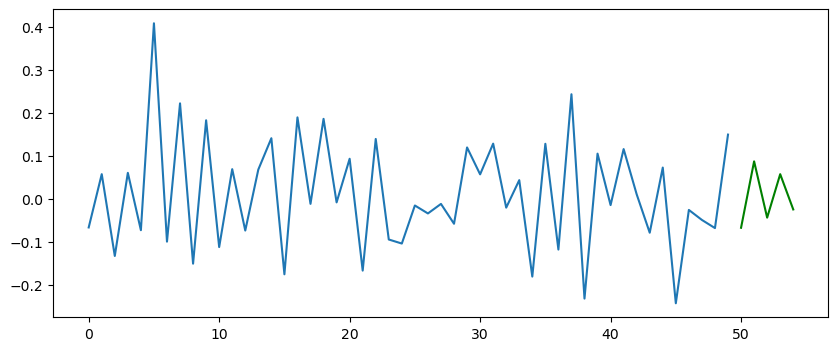

In [19]:
plt.figure(figsize=(10,4))
plt.plot(xvals)
forecast = model.forecast(5)
forecast
plt.plot(range(len(xvals), len(xvals) + 5), forecast, color='g')

# Bayesian Analysis with PyMC3
***

# Priors:
## $\phi_1 \sim N(0,20)$
## $\phi_2 \sim N(0,20)$
## $\sigma \sim Exp(1)$
***

# Likelihood:
## $x_t|\phi_1, \phi_2, \sigma, x_{t-1}, x_{t-2} \sim N(\phi_1 x_{t-1} + \phi_2 x_{t-2}, \sigma)$
***

# Posterior
## $\phi_1, \phi_2, \sigma|x \sim ?$
***

In [21]:
with pm.Model() as bayes_model:
    #priors
    phi = pm.Normal("phi", mu=0, sigma=20, shape=2)
    sigma = pm.Exponential("sigma", lam=1)

    #Likelihood
    likelihood = pm.AR("x", phi, sigma, observed=xvals)

    #posterior
    trace = pm.sample(1000, cores=2)
    


c:\Users\salmank\anaconda3\envs\pymc_env_5\Lib\site-packages\pymc\distributions\timeseries.py:558: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100, shape=...)`. You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [phi, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 72 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


<Figure size 700x700 with 0 Axes>

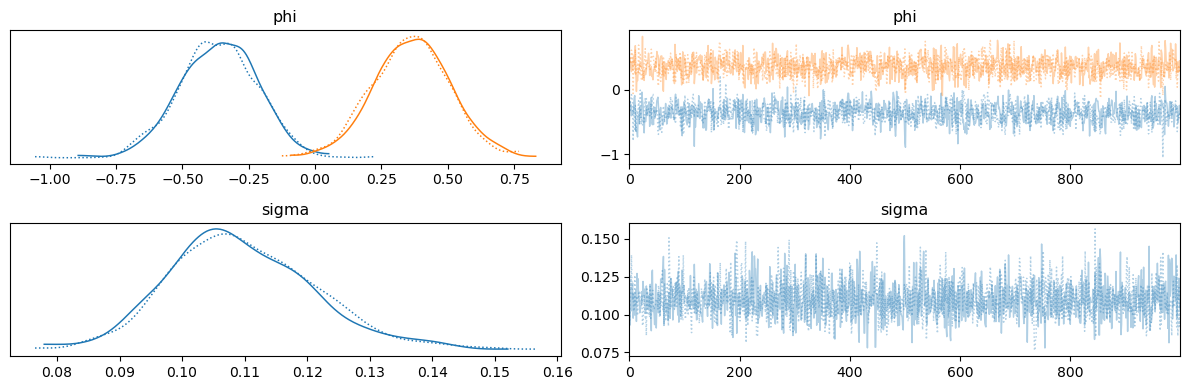

In [25]:
plt.figure(figsize=(7, 7))
pm.plot_trace(trace)
plt.tight_layout()

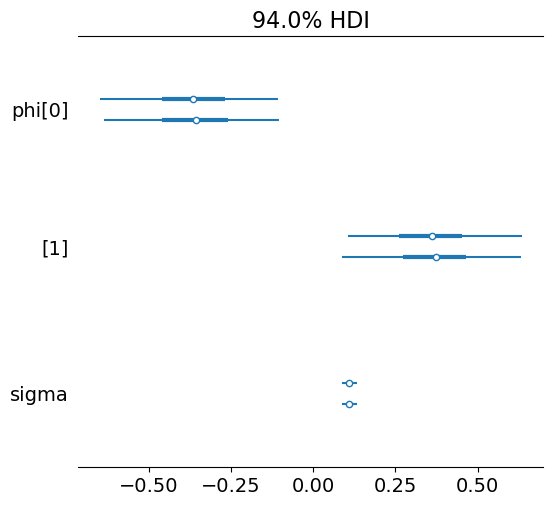

In [36]:
az.plot_forest(trace, var_names=["phi","sigma"]);


# Parameter Distributions

In [58]:
import pandas as pd

In [60]:
phi1_vals = pd.DataFrame(trace.posterior["phi"][0,:,0])
phi2_vals = pd.DataFrame(trace.posterior["phi"][0,:,1])
sigma_vals = pd.DataFrame(trace.posterior["sigma"][0,:])


<Figure size 1000x400 with 0 Axes>

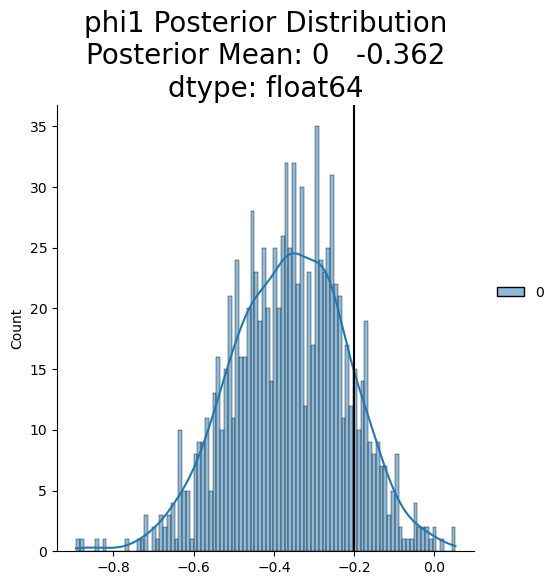

<Figure size 1000x400 with 0 Axes>

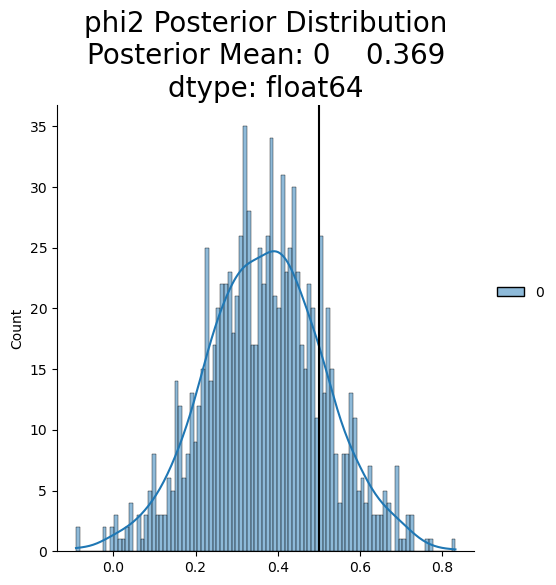

<Figure size 1000x400 with 0 Axes>

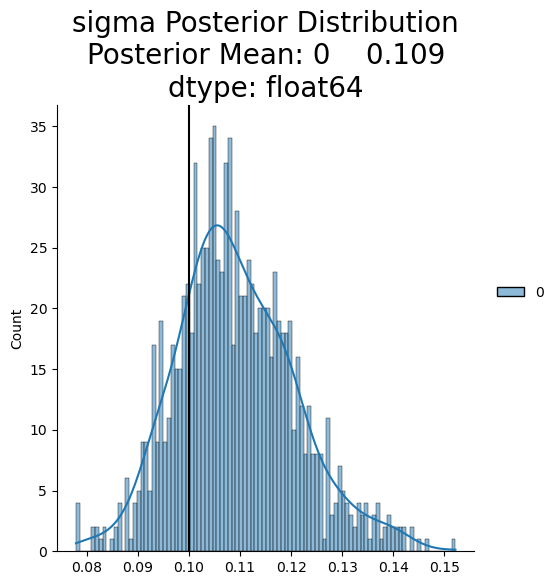

In [69]:
plt.figure(figsize=(10,4))
sns.displot(phi1_vals, kde=True, bins=100)
plt.title("phi1")
plt.axvline(true_phi_1, color='k')
plt.title('phi1 Posterior Distribution\nPosterior Mean: %s'% round(phi1_vals.mean(), 3), fontsize=20)
plt.show()


plt.figure(figsize=(10,4))
sns.displot(phi2_vals, kde=True, bins=100)
plt.axvline(true_phi_2, color='k')
plt.title('phi2 Posterior Distribution\nPosterior Mean: %s'%round(phi2_vals.mean(), 3), fontsize=20)
plt.show()

plt.figure(figsize=(10,4))
sns.displot(sigma_vals, kde=True, bins=100)
plt.axvline(true_sigma, color='k')
plt.title('sigma Posterior Distribution\nPosterior Mean: %s'%round(sigma_vals.mean(), 3), fontsize=20)
plt.show()

# Forecast Next Values

In [71]:
phi1_vals[0]

0     -0.547876
1     -0.182828
2     -0.306024
3     -0.231130
4     -0.403055
         ...   
995   -0.510737
996   -0.348297
997   -0.391452
998   -0.241192
999   -0.351840
Name: 0, Length: 1000, dtype: float64

In [78]:
num_samples = 10000
forecasted_vals = []
num_periods = 5

for _ in range(num_samples):
    curr_vals = list(xvals.copy())
    
    phi1_val = np.random.choice(phi1_vals[0])
    phi2_val = np.random.choice(phi2_vals[0])
    sigma_val = np.random.choice(sigma_vals[0])
    
    for _ in range(num_periods):
        curr_vals.append(curr_vals[-1]*phi1_val + curr_vals[-2]*phi2_val + np.random.normal(0, sigma_val))
    forecasted_vals.append(curr_vals[-num_periods:]) 
forecasted_vals = np.array(forecasted_vals)
forecast

array([-0.06680764,  0.08735786, -0.04333067,  0.05759544, -0.02427584])

<Figure size 1000x400 with 0 Axes>

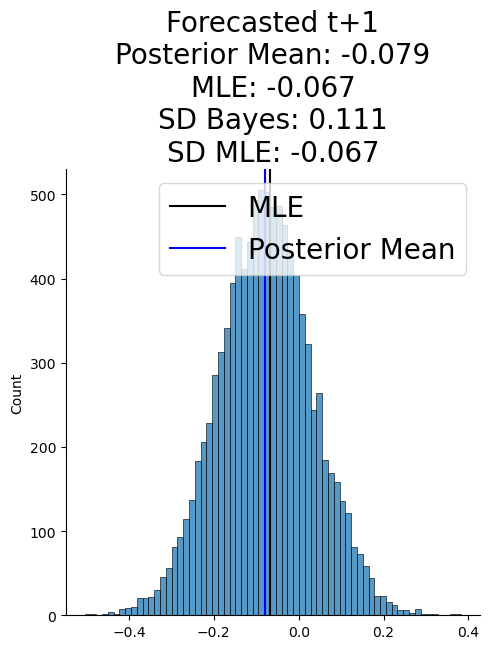

<Figure size 1000x400 with 0 Axes>

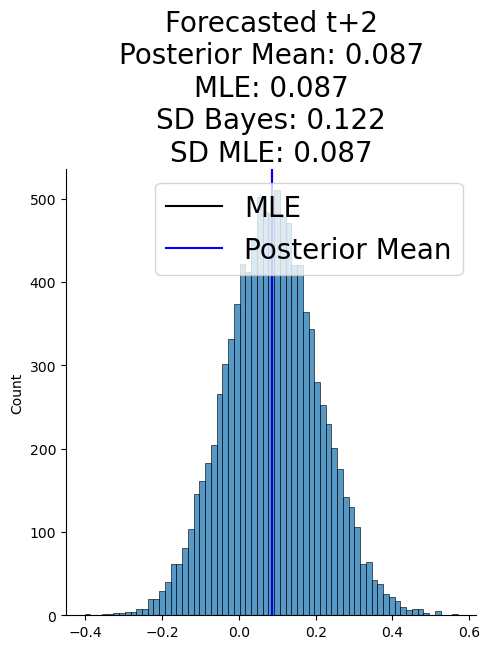

<Figure size 1000x400 with 0 Axes>

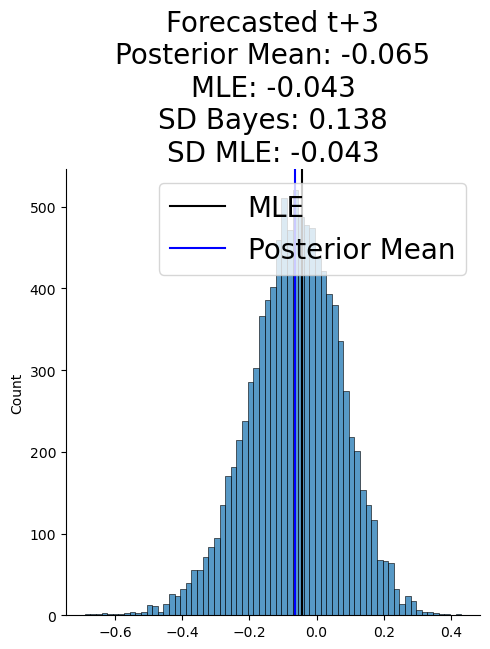

<Figure size 1000x400 with 0 Axes>

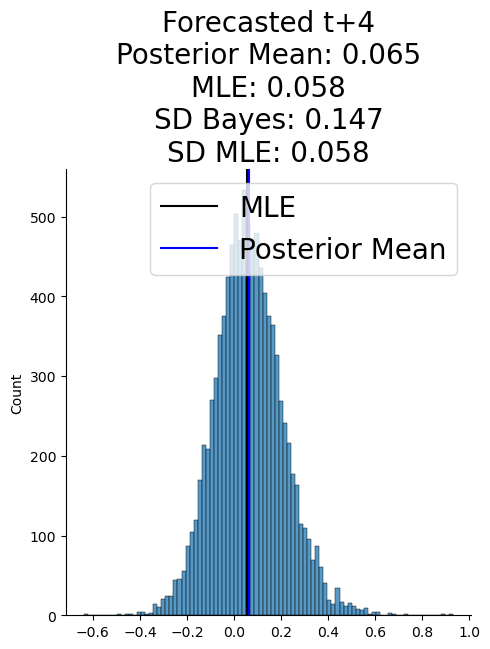

<Figure size 1000x400 with 0 Axes>

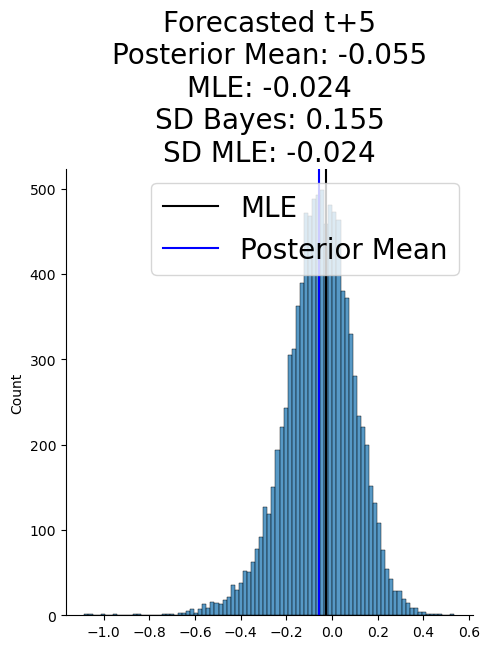

In [83]:
for i in range(num_periods):
    plt.figure(figsize=(10,4))
    vals = forecasted_vals[:,i]
    mu, dev = round(vals.mean(), 3), round(vals.std(), 3)
    sns.displot(vals)
    p1 = plt.axvline(forecast[i], color='k')
    p2 = plt.axvline(vals.mean(), color='b')
    plt.legend((p1,p2), ('MLE', 'Posterior Mean'), fontsize=20)
    plt.title('Forecasted t+%s\nPosterior Mean: %s\nMLE: %s\nSD Bayes: %s\nSD MLE: %s'%((i+1), mu, round(forecast[i],3), dev, round(forecast[i],3)), fontsize=20)